# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split

%config InlineBackend.figure_format = 'retina'

# Import Original Data

Importing the original data harvested from Yahoo Finance using pandas to read in the CSV file.

In [2]:
# Read in the CSV file generated by scraper
df = pd.read_csv('TSLA.csv')

# Preview the DataFrame
print(df.shape)
df.head()

(2569, 7)


,Date,Open,High,Low,Close*,Adj Close**,Volume
0,"Sep 09, 2020",356.60,369.00,341.51,366.28,366.28,78582200
1,"Sep 08, 2020",356.00,368.74,329.88,330.21,330.21,115465700
2,"Sep 04, 2020",402.81,428.00,372.02,418.32,418.32,110321900
3,"Sep 03, 2020",407.23,431.80,402.00,407.00,407.00,87596100
4,"Sep 02, 2020",478.99,479.04,405.12,447.37,447.37,96176100


In [3]:
# Set "Date" column to datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Resetting Date column as the index for the dataframe
df.set_index('Date', inplace = True)
df.sort_index(inplace = True)

# Tesla executed a 5:1 stock split on August 31, 2020. This new row contained only text data
# and had to be filtered out. In addition, other rows had to be changed back to float type.
df = df[df['Open'] != '5:1 Stock Split'].astype(float).copy()

# Removed special characters in column names and replaced spaces with underscores for better formatting.
df.columns = df.columns.map(lambda x: x.lower().replace('*', '').replace(' ', '_'))

# Created a new column called "daily_returns" to reflect the percent change in closing stock prices day over day.
df['daily_returns'] = df['close'].pct_change()

df.head()

,open,high,low,close,adj_close,volume,daily_returns
Date,,,,,,,
2010-06-29,3.80,5.00,3.51,4.78,4.78,93831500.0,NaN
2010-06-30,5.16,6.08,4.66,4.77,4.77,85935500.0,-0.002092
2010-07-01,5.00,5.18,4.05,4.39,4.39,41094000.0,-0.079665
2010-07-02,4.60,4.62,3.74,3.84,3.84,25699000.0,-0.125285
2010-07-06,4.00,4.00,3.17,3.22,3.22,34334500.0,-0.161458


# Exploratory Data Analysis

Performed simple EDA. I am checking for any corrupt rows of data or missing values. As I retrieved my data from Yahoo Finance, I was expecting to have a full set of clean data.

In [4]:
# Check shape
print(df.shape)

'''
Used the resample method to ensure the data was in chronological order by date. There were several 
duplicate rows of data in the final dataframe so I filtered for the first occurrence with the first() method. 
Finally, because trading only happens Monday through Friday, I used a front fill method to populate weekend dates with 
Fridays' values.
'''
df = df.resample('D').first().ffill()
print(df.isna().sum())

df

(2568, 7)
open             0
high             0
low              0
close            0
adj_close        0
volume           0
daily_returns    1
dtype: int64


,open,high,low,close,adj_close,volume,daily_returns
Date,,,,,,,
2010-06-29,3.80,5.00,3.51,4.78,4.78,93831500.0,NaN
2010-06-30,5.16,6.08,4.66,4.77,4.77,85935500.0,-0.002092
2010-07-01,5.00,5.18,4.05,4.39,4.39,41094000.0,-0.079665
2010-07-02,4.60,4.62,3.74,3.84,3.84,25699000.0,-0.125285
2010-07-03,4.60,4.62,3.74,3.84,3.84,25699000.0,-0.125285
...,...,...,...,...,...,...,...
2020-09-05,402.81,428.00,372.02,418.32,418.32,110321900.0,0.027813
2020-09-06,402.81,428.00,372.02,418.32,418.32,110321900.0,0.027813
2020-09-07,402.81,428.00,372.02,418.32,418.32,110321900.0,0.027813


# Visualizing the Original Time Series

Simple time plot used to visualize the data. We are looking for obvious patterns of trend or seasonality, as well as overall variability.

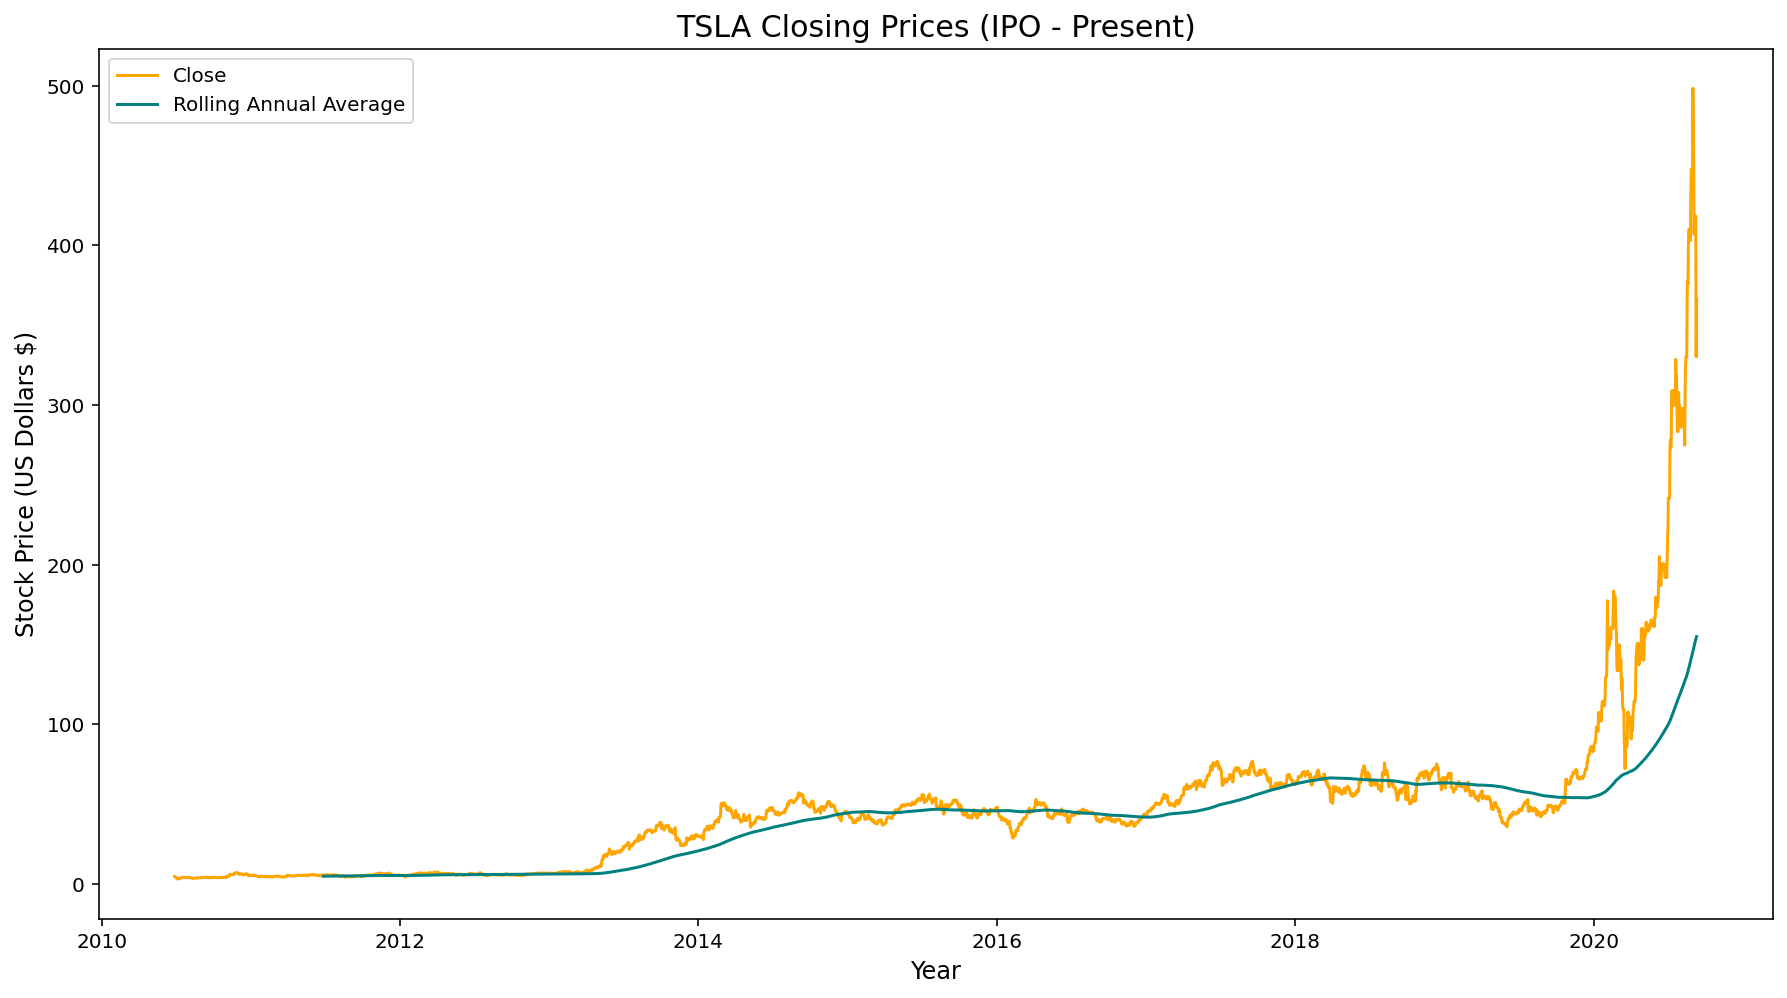

In [5]:
plt.figure(figsize = (15, 8))
plt.plot(df['close'], label = 'Close', color = 'orange')
plt.plot(df['close'].rolling(365).mean(), label = 'Rolling Annual Average', color = 'teal')
plt.xlabel('Year', size = 12)
plt.ylabel('Stock Price (US Dollars $)', size = 12)
plt.title('TSLA Closing Prices (IPO - Present)', size = 15)
plt.legend();

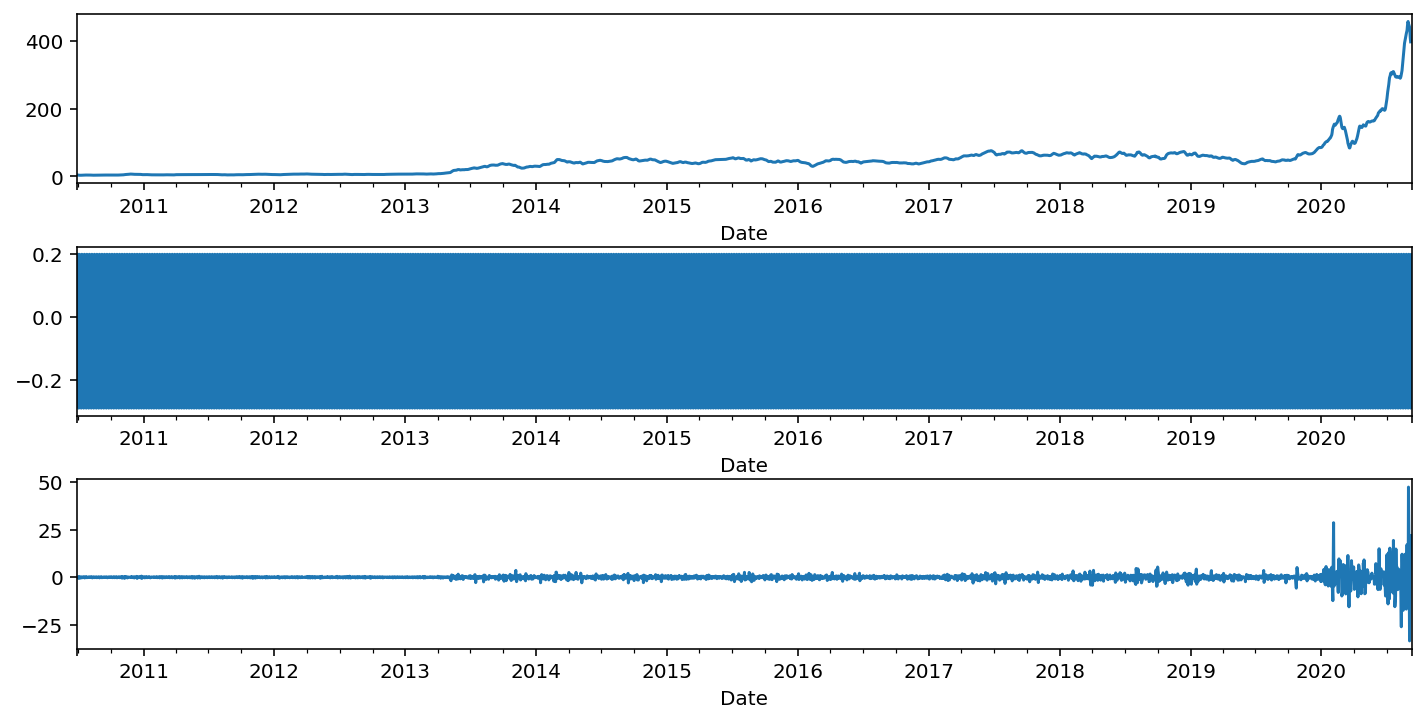

In [6]:
fig, ax = plt.subplots(nrows = 3, figsize = (10, 5))
plt.tight_layout()

m = seasonal_decompose(df['close'])

# Visually, there doesn't appear to be any seasonality in our data. 
# There is, however, an obvious trend (possibly exponential) The seasonal component
# is not applicable in our analysis.

m.trend.plot(ax = ax[0])
m.seasonal.plot(ax = ax[1])
m.resid.plot(ax = ax[2]);

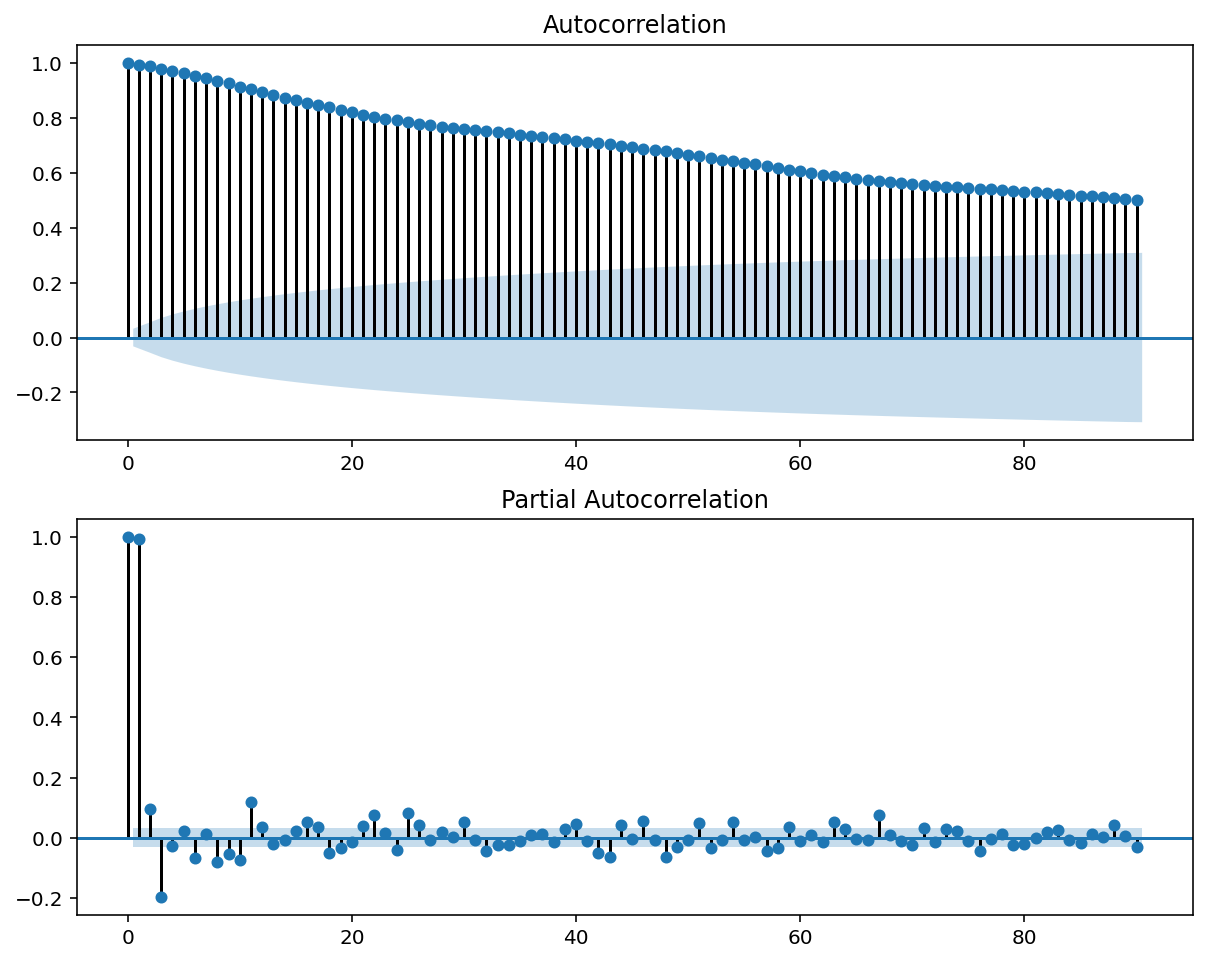

In [7]:
fig, ax = plt.subplots(nrows = 2, figsize = (10, 8))
# We can immediately tell that the data needs to be stationarized based on how
# many lags it takes before the ACF values cut off below our 95% confidence interval
# But we should still perform an ADFuller test to confirm
plot_acf(df['close'], lags = 90, ax = ax[0])

# Just by eyeballing the PACF chart, we can't confirm whether or not seasonality exists.
# We can see that there is some variation explained by certain lags around 30 days, 60 days, and 90 days
plot_pacf(df['close'], lags = 90, ax = ax[1]);

# First Difference of Closing Price

Stationarity is crucial when performing time series analysis. The statistical properties of a process generating a time series does not change over time. Not that the series doesn’t change over time, rather, the way the series changes does not change over time. Time series data is merely a single run of a stochastic process. Stationarity allows us to treat this single process as if it were replicable. We're able to predict the way the series changes and all our assumptions for statistical inference are satisfied.

#### ADFuller Test

The Augmented Dickey Fuller Test will confirm whether our time series is indeed stationary by testing for the unit root. The null hypothesis states that there is a unit root present, while the alternative hypothesis states otherwise. 

In [8]:
def adf_results(data):
    adf = adfuller(data)
    results = pd.Series(adf[0:2], index = ['Test Statistic', 'p-value'])
    
    return results

# We're setting alpha = 0.01
# Because our p-value is way higher than alpha, we do not have enough evidence to reject the null hypothesis
# and therefore cannot conclude that our data is stationary. 
print(adf_results(df['close']), '\n')

# We've computed a p-value lower than our alpha level of 0.05. We can proceed with modeling our differenced data.
print(adf_results(df['close'].diff().dropna()))

Test Statistic    5.966601
p-value           1.000000
dtype: float64 

Test Statistic   -1.345200e+01
p-value           3.668627e-25
dtype: float64


In [9]:
# Taking the first-difference of our closing data
df['diff_close'] = df['close'].diff()
df.head()

,open,high,low,close,adj_close,volume,daily_returns,diff_close
Date,,,,,,,,
2010-06-29,3.80,5.00,3.51,4.78,4.78,93831500.0,NaN,NaN
2010-06-30,5.16,6.08,4.66,4.77,4.77,85935500.0,-0.002092,-0.01
2010-07-01,5.00,5.18,4.05,4.39,4.39,41094000.0,-0.079665,-0.38
2010-07-02,4.60,4.62,3.74,3.84,3.84,25699000.0,-0.125285,-0.55
2010-07-03,4.60,4.62,3.74,3.84,3.84,25699000.0,-0.125285,0.00


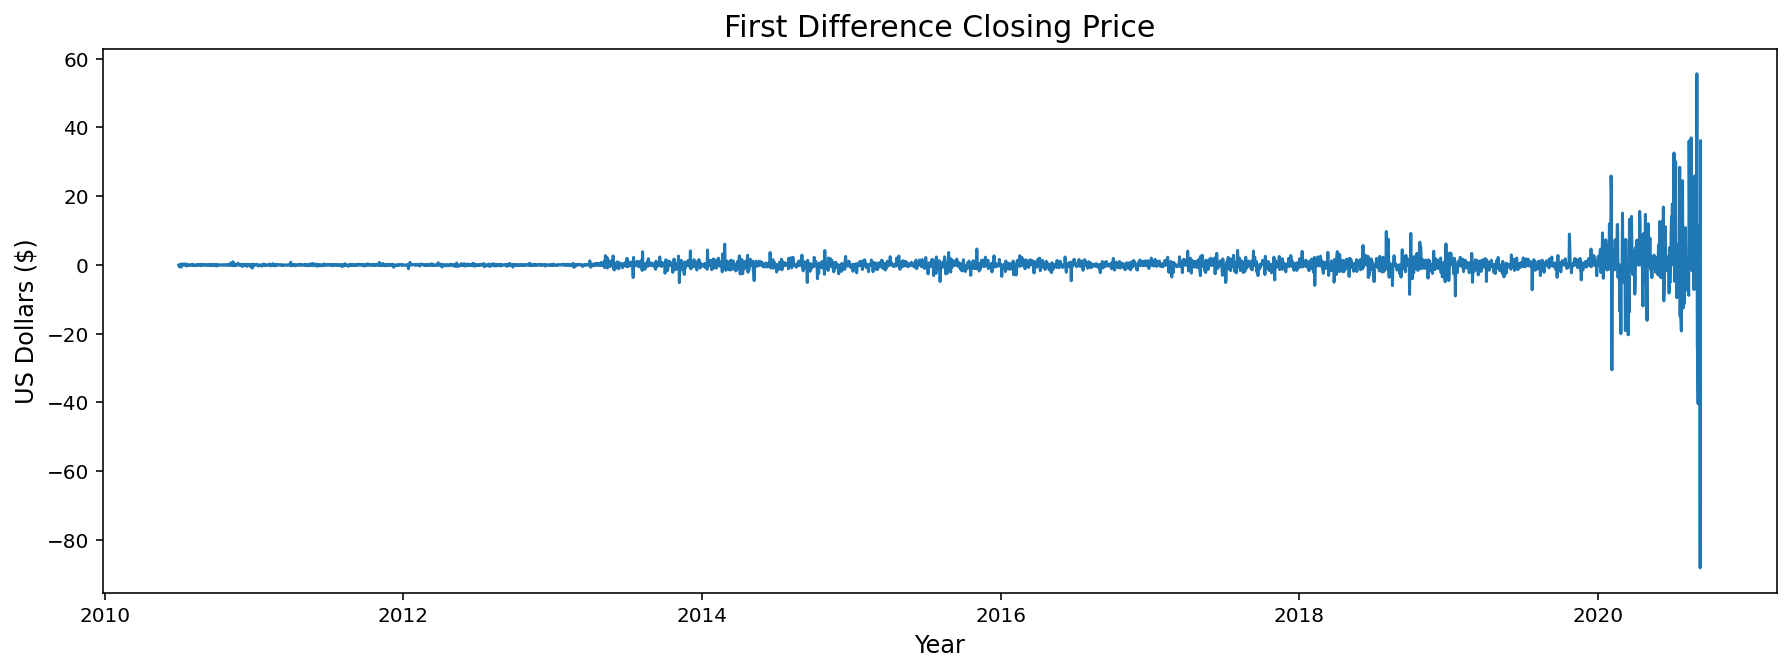

In [10]:
plt.figure(figsize = (15, 5))
plt.plot(df['diff_close'])
plt.xlabel('Year', size = 12)
plt.ylabel('US Dollars ($)', size = 12)
plt.title('First Difference Closing Price', size = 15);

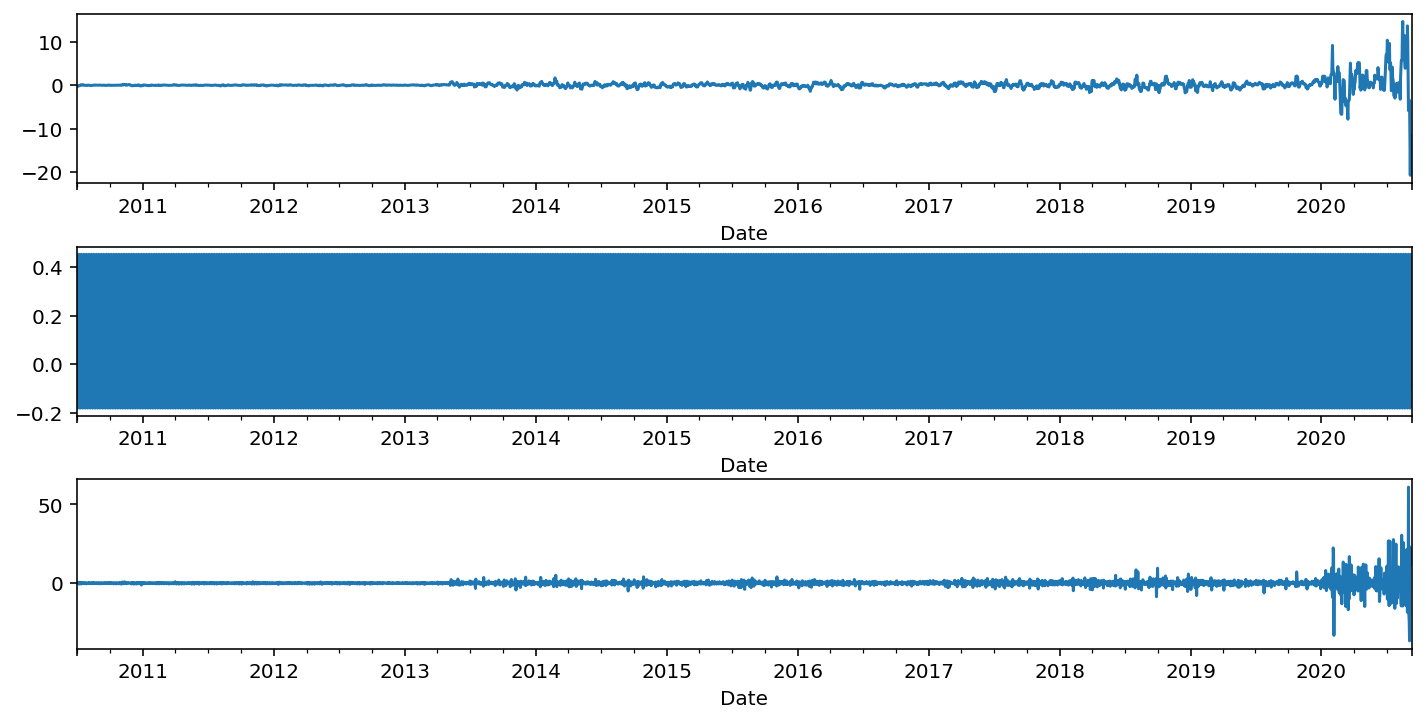

In [11]:
fig, ax = plt.subplots(nrows = 3, figsize = (10, 5))
plt.tight_layout()

m = seasonal_decompose(df['diff_close'].dropna())

# Visually, there doesn't appear to be any seasonality in our data. 
# There is, however, an obvious trend (possibly exponential) The seasonal component provided
# is probably not helpful in our analysis in this case.

m.trend.plot(ax = ax[0])
m.seasonal.plot(ax = ax[1])
m.resid.plot(ax = ax[2]);

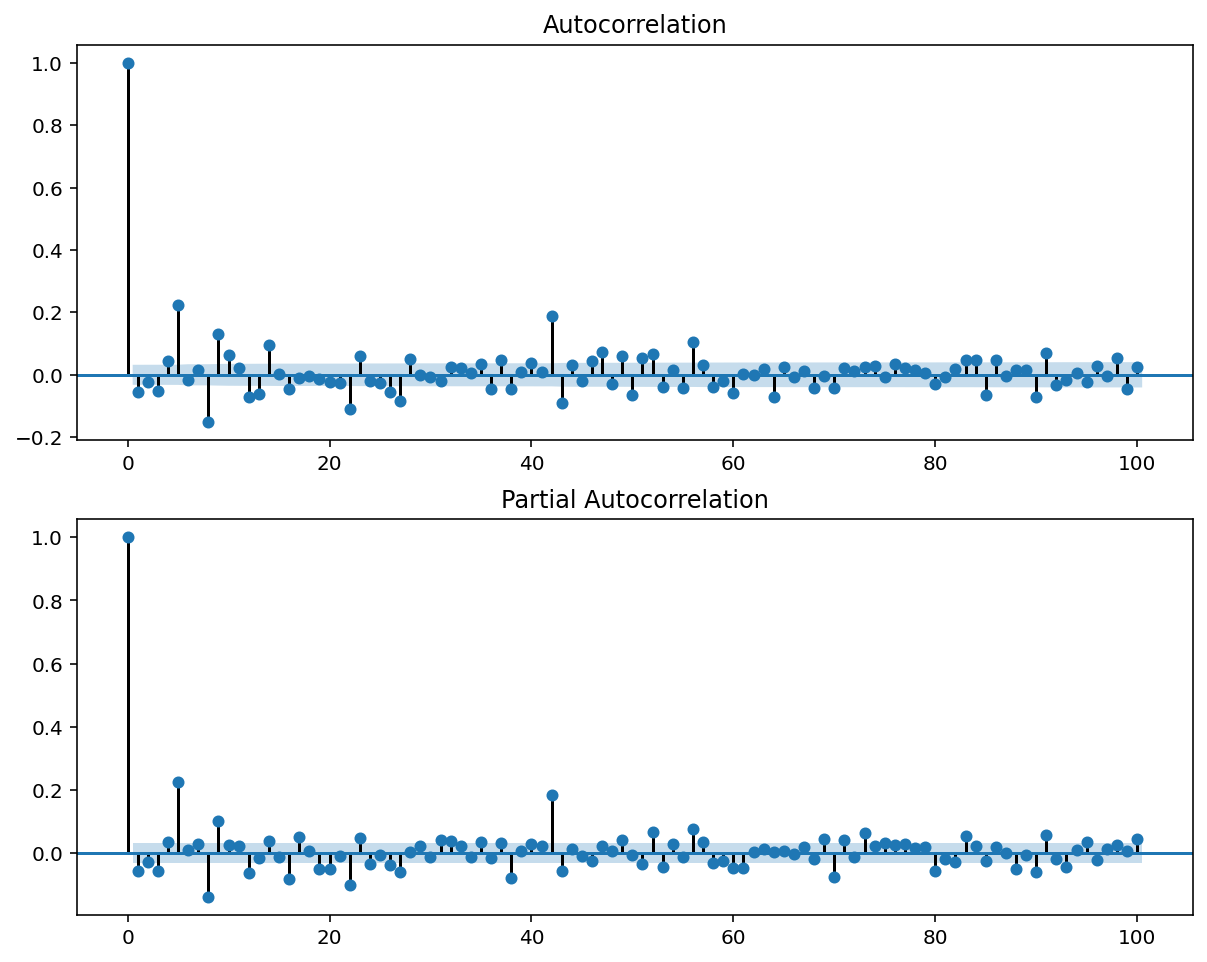

In [12]:
fig, ax = plt.subplots(nrows = 2, figsize = (10, 8))
plot_acf(df['diff_close'].dropna(), lags = 100, ax = ax[0])
plot_pacf(df['diff_close'].dropna(), lags = 100, ax = ax[1]);

# Second Difference Closing Price

Rules to follow when identifying the order of differencing needed:

- If the series has positive autocorrelations out to a high number of lags, then it probably needs a higher order of differencing.
- If the lag-1 autocorrelation is zero or negative, or the autocorrelations are all small and patternless, then the series does not need a higher order of  differencing. If the lag-1 autocorrelation is -0.5 or more negative, the series may be overdifferenced.
- The optimal order of differencing is often the order of differencing at which the standard deviation is lowest.

Source: https://people.duke.edu/~rnau/411arim2.htm

In [13]:
# Here we call the diff() twice to compute the second difference price. 
df['diff_close_2'] = df['close'].diff().diff()
df.head()

,open,high,low,close,adj_close,volume,daily_returns,diff_close,diff_close_2
Date,,,,,,,,,
2010-06-29,3.80,5.00,3.51,4.78,4.78,93831500.0,NaN,NaN,NaN
2010-06-30,5.16,6.08,4.66,4.77,4.77,85935500.0,-0.002092,-0.01,NaN
2010-07-01,5.00,5.18,4.05,4.39,4.39,41094000.0,-0.079665,-0.38,-0.37
2010-07-02,4.60,4.62,3.74,3.84,3.84,25699000.0,-0.125285,-0.55,-0.17
2010-07-03,4.60,4.62,3.74,3.84,3.84,25699000.0,-0.125285,0.00,0.55


Test Statistic   -1.578813e+01
p-value           1.110465e-28
dtype: float64


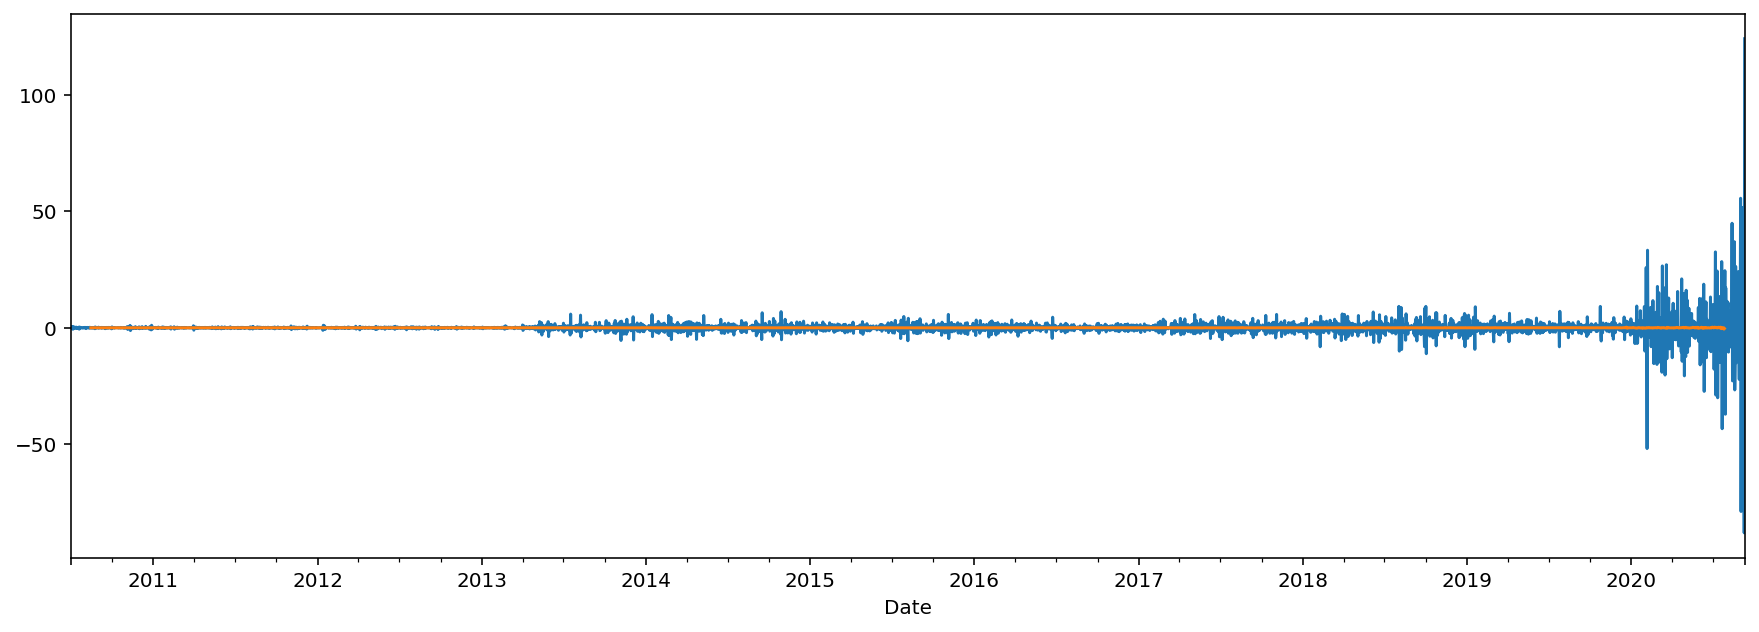

In [14]:
n = seasonal_decompose(df['diff_close_2'].dropna(), period = 90)
n.observed.plot(figsize = (15, 5))
n.trend.plot()

print(adf_results(df['diff_close_2'].dropna()))

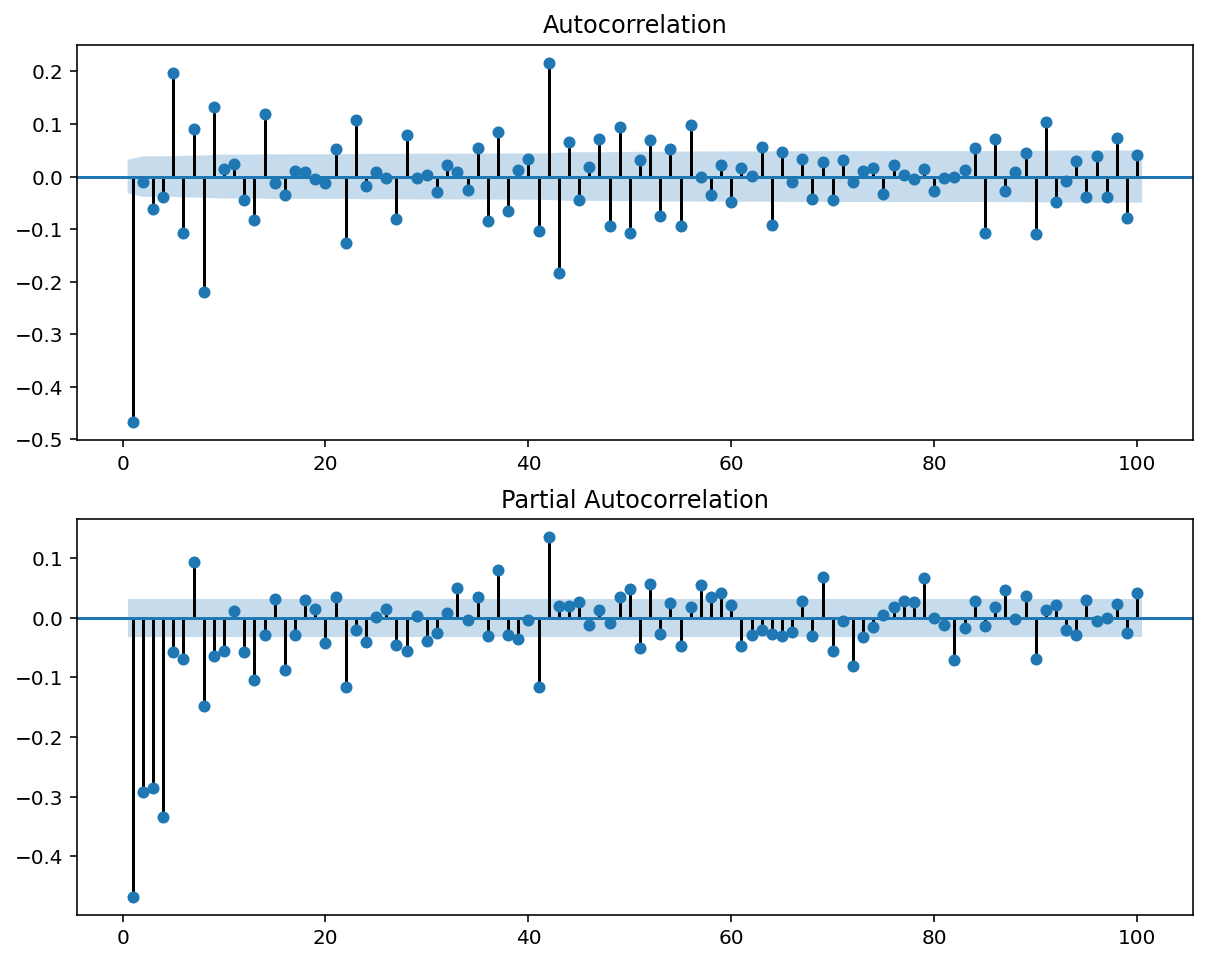

In [15]:
# We can see at lag-1 that the ACF and PACF values are extreme and negative which indicates overdifferencing.
# Because of all the noise in our first-differenced correlogram 
# we're going to try other methods to stationarize.
fig, ax = plt.subplots(nrows = 2, figsize = (10, 8))
plot_acf(df['diff_close_2'].dropna(), lags = 100, ax = ax[0], zero = False)
plot_pacf(df['diff_close_2'].dropna(), lags = 100, ax = ax[1], zero = False);

# Log Transformation of Closing Price

Log Transformation on our data is useful for several reasons: 
- Decreases variability and noise in our data
- Adjusts for inflation and linearizes trend
- In our particular set of TSLA data, we learn from log transforming that 5 natural log units over 10 years translates to an average annual increase of 50%

In [16]:
# In an attempt to smooth out the exponential trend, I'm going to take the log of the closing price. 
df['log_close'] = np.log(df['close'])

# Check to see if the logged closing price is stationary:
print(adf_results(df['log_close']), '\n')

# Because our p-value is again way higher than our alpha level of 0.01, we will take the first order difference
# and check for stationarity 
df['log_diff'] = df['log_close'].diff()

# Our p-value here with the differenced logged prices is practically 0. We can proceed with stationarity assumption.
adf_results(df['log_diff'].dropna())

Test Statistic   -0.282964
p-value           0.927883
dtype: float64 



Test Statistic   -20.313097
p-value            0.000000
dtype: float64

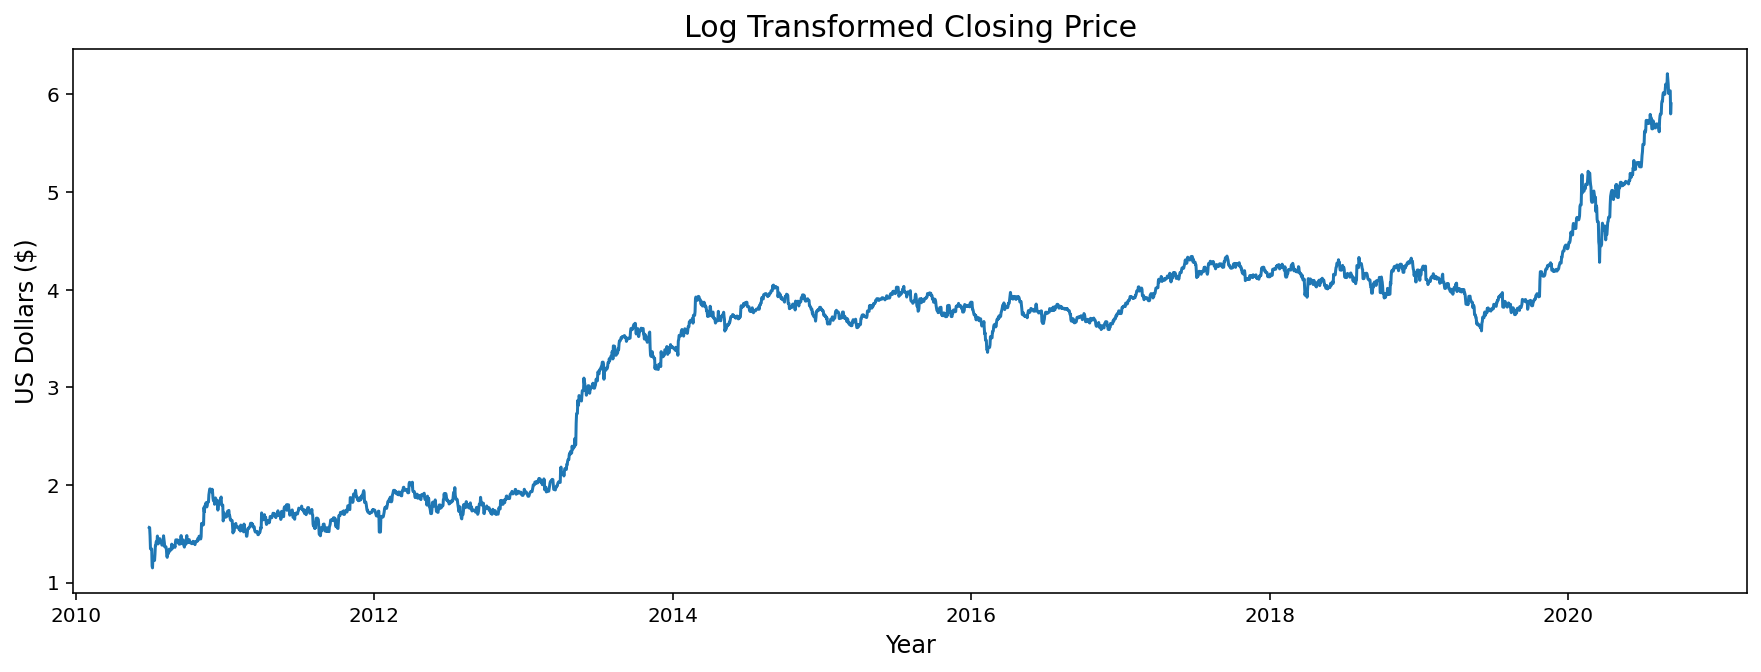

In [17]:
plt.figure(figsize = (15, 5))
plt.plot(df['log_close'])
plt.xlabel('Year', size = 12)
plt.ylabel('US Dollars ($)', size = 12)
plt.title('Log Transformed Closing Price', size = 15);

# First Difference of Log Transformed Closing Price 

This can be interpreted as the percent difference (or percent daily returns) of the original data. In this case, we're seeing the data hover around the +/- 10% range.

The ACF plot of the first differenced log transformed closing price shows no significant correlation between day-to-day changes which suggests our data follows a geometric random-walk with drift.

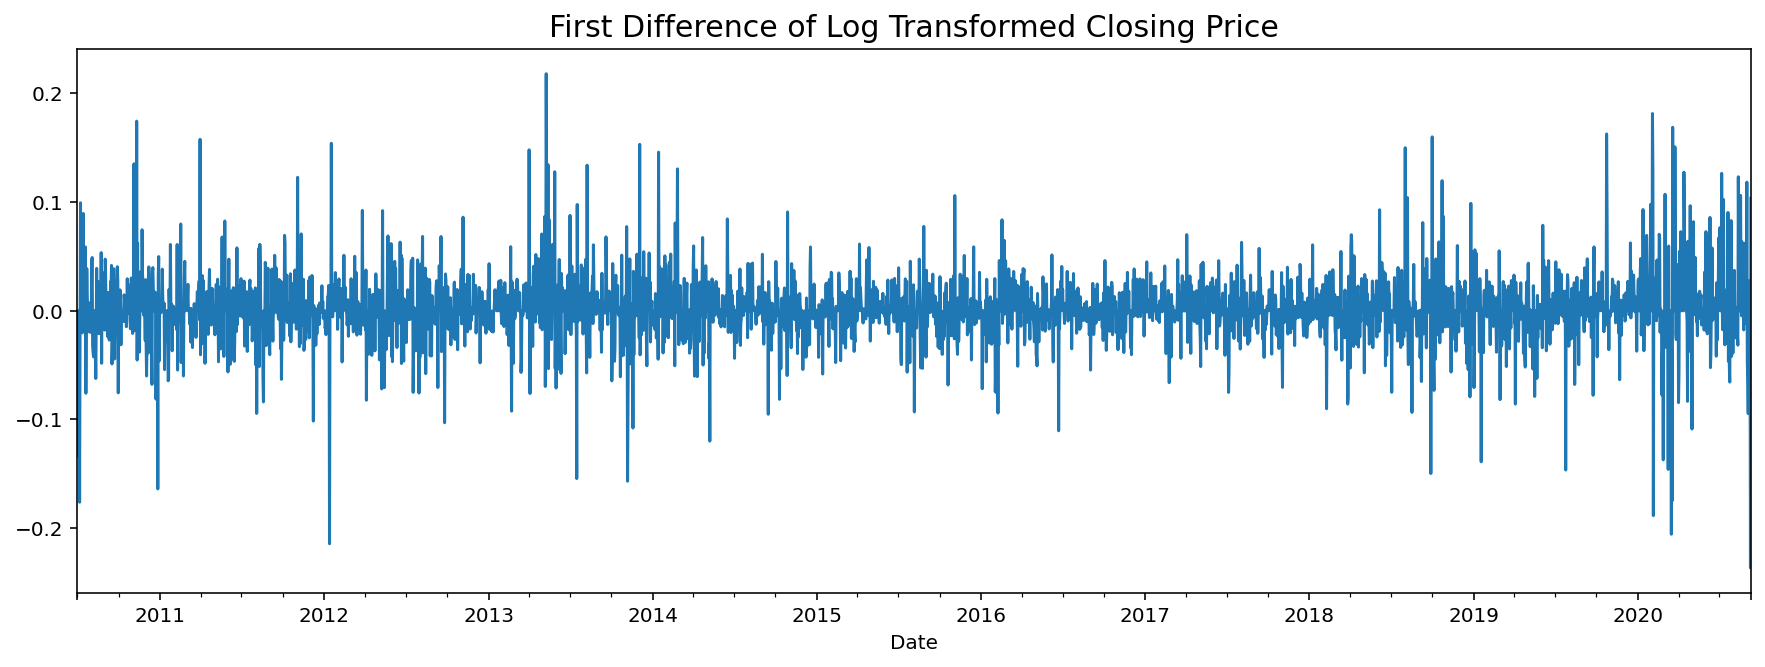

In [18]:
n = seasonal_decompose(df['log_diff'].dropna())
n.observed.plot(figsize = (15, 5))
plt.title('First Difference of Log Transformed Closing Price', size = 15);

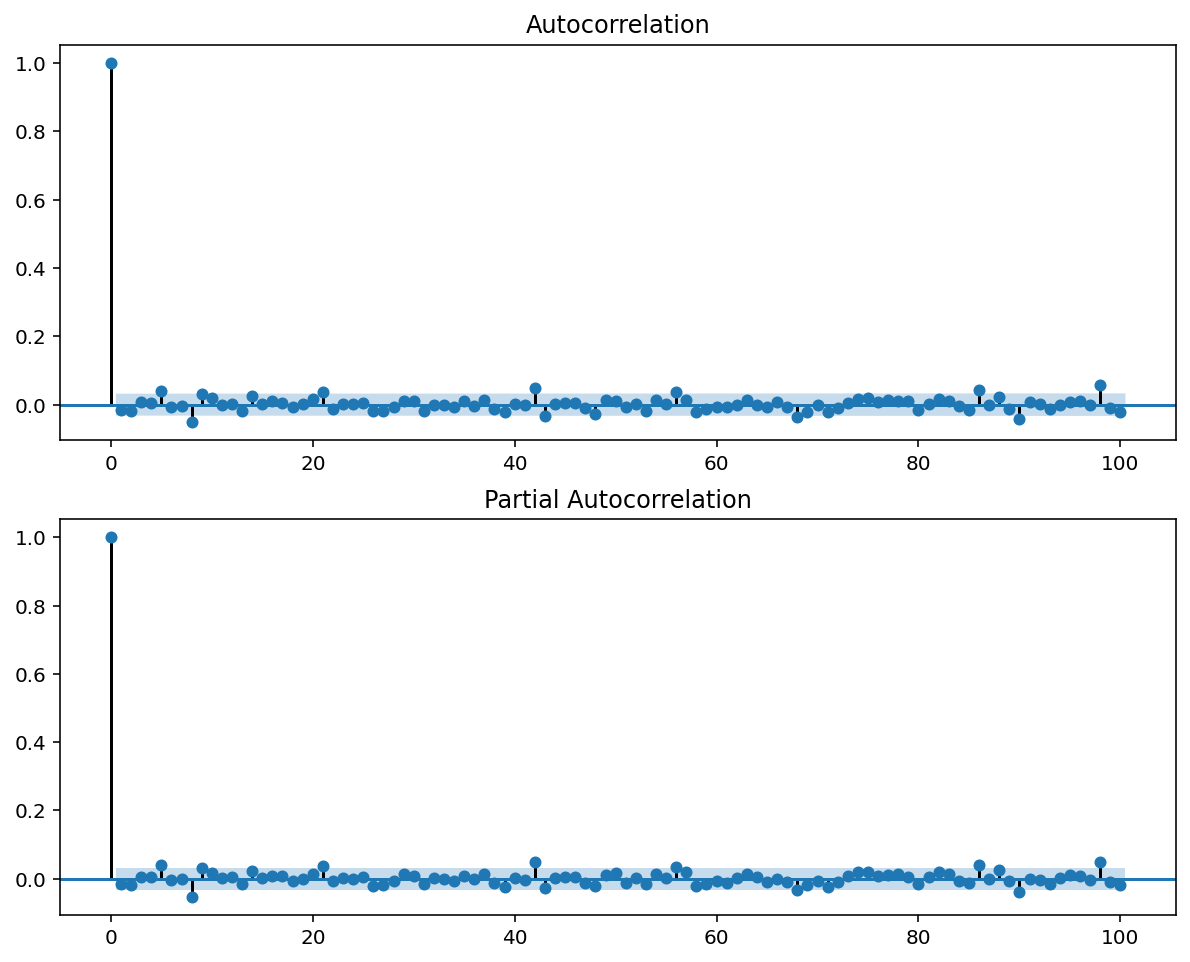

In [19]:
fig, ax = plt.subplots(nrows = 2, figsize = (10, 8))
plot_acf(df['log_diff'].dropna(), lags = 100, ax = ax[0])
plot_pacf(df['log_diff'].dropna(), lags = 100, ax = ax[1]);

# ARIMA Model (Closing Price)

Using the ACF and PACF plots:

Ideally, your residuals will have no autocorrelation and your model would have captured all the signals. In practice, for non-seasonal data, you only tune for either p OR q as their effects may cancel one another.

Tuning for ARIMA(p, d, q):
- Adjust q for spikes at lags 1-3 in residual ACF plot
- Adjust p for spikes at lags 1-3 in residual PACF plot

In [20]:
# Displaying the original DataFrame for reference
df

,open,high,low,close,adj_close,volume,daily_returns,diff_close,diff_close_2,log_close,log_diff
Date,,,,,,,,,,,
2010-06-29,3.80,5.00,3.51,4.78,4.78,93831500.0,NaN,NaN,NaN,1.564441,NaN
2010-06-30,5.16,6.08,4.66,4.77,4.77,85935500.0,-0.002092,-0.01,NaN,1.562346,-0.002094
2010-07-01,5.00,5.18,4.05,4.39,4.39,41094000.0,-0.079665,-0.38,-0.37,1.479329,-0.083017
2010-07-02,4.60,4.62,3.74,3.84,3.84,25699000.0,-0.125285,-0.55,-0.17,1.345472,-0.133857
2010-07-03,4.60,4.62,3.74,3.84,3.84,25699000.0,-0.125285,0.00,0.55,1.345472,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2020-09-05,402.81,428.00,372.02,418.32,418.32,110321900.0,0.027813,0.00,-11.32,6.036247,0.000000
2020-09-06,402.81,428.00,372.02,418.32,418.32,110321900.0,0.027813,0.00,0.00,6.036247,0.000000
2020-09-07,402.81,428.00,372.02,418.32,418.32,110321900.0,0.027813,0.00,0.00,6.036247,0.000000


In [21]:
from statsmodels.tsa.arima_model import ARIMA

### Train-Test Split

As ARIMA models perform most effectively for short-term forecasts, I've set the test size in our split to be exactly 7 days, or roughly 0.2% of our 3720 days of available data.

In [22]:
# Train test split our y variable (First order difference of the logged closing price)
# leaving the most recent 10% of our data as our test set.
y_train, y_test = train_test_split(df['log_close'],
                                   test_size = 0.0018, # <- Test size is exactly 7 days
                                   shuffle = False)

In [23]:
model = ARIMA(endog = y_train.dropna(),
              order = (0, 1, 0)) # ARIMA(0, 1, 0) represents a simple random-walk model.

arima = model.fit() # statsmodels ARIMA algorithm performs differencing for our data as indicated by the
                    # middle value in the "order" parameter.

preds = model.predict(arima.params,
                      start = y_test.index[0], # First day to forecast in our test set
                      end = y_test.index[-1])  # Final day to forecast in our test set

arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.log_close   No. Observations:                 3718
Model:                 ARIMA(0, 1, 0)   Log Likelihood                7902.812
Method:                           css   S.D. of innovations              0.029
Date:                Mon, 12 Oct 2020   AIC                         -15801.623
Time:                        11:52:06   BIC                         -15789.181
Sample:                    06-30-2010   HQIC                        -15797.196
                         - 09-02-2020                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.000      2.577      0.010       0.000       0.002
==============================================================================
"""

The prediction generated by our model is simply a list of values in sequential order following the start and end date parameters in the form of day-to-day changes, as we have taken the first order difference of the original data.

In order to translate these values back to real stock prices, I've performed a row-wise merge of the final day in the training data with the forcasted data and computed the cumulative sum to undo the differencing. Each value now represents the predicted closing price for the corresponding day.

In [24]:
# After computing the cumulative sum for each day, I sliced the array to exclude the first value that was taken
# from the training set. "preds" contains ONLY the values forecasted for the testing days.
preds = pd.Series(np.r_[df['log_close'][y_train.index][-1], preds[:8]].cumsum()[1:])

preds.index = df['log_close'][y_test.index][:8].index

preds

Date
2020-09-03    6.104607
2020-09-04    6.105828
2020-09-05    6.107048
2020-09-06    6.108269
2020-09-07    6.109490
2020-09-08    6.110711
2020-09-09    6.111932
Freq: D, dtype: float64

In [25]:
# Using the forecast() method from our ARIMAResults object, I've obtained the 95% confidence intervals
# for each subsequent day following the last day of our testing data set.

lower_bounds = []
upper_bounds = []

for a, b in arima.forecast(7)[2]: # The confidence intervals are the third elements in the tuple returned by the method
    '''
    'a' variable represents the lower bounds and 'b' variable represents the upper bounds
    for each prediction. Separating the bounds into their own series will allow me to easily
    plot them in the graph below.
    '''
    lower_bounds.append(a)
    upper_bounds.append(b)

print(lower_bounds)
print(upper_bounds)

[6.047996641371728, 6.02576875020691, 6.008996737155984, 5.9950488944323235, 5.982905852181253, 5.9720448154810555, 5.9621552201680705]
[6.161216948469652, 6.1858864440408405, 6.205100061498138, 6.22148950862817, 6.236074155285611, 6.2493767963921805, 6.261707996111537]


In [26]:
# make_intervals() converts our lists of upper and lower bounds of each day's forecast into a pandas series
# aligned with the test set date index. (For visualization)
def make_intervals(n):
    n = np.exp(pd.Series(n, index = y_test.index))
    return n

lower = make_intervals(lower_bounds)
upper = make_intervals(upper_bounds)

display(lower)
display(upper)

Date
2020-09-03    423.264230
2020-09-04    413.959751
2020-09-05    407.074712
2020-09-06    401.436312
2020-09-07    396.591131
2020-09-08    392.307047
2020-09-09    388.446410
Freq: D, dtype: float64

Date
2020-09-03    474.004563
2020-09-04    485.843446
2020-09-05    495.268511
2020-09-06    503.452571
2020-09-07    510.849055
2020-09-08    517.690098
2020-09-09    524.113360
Freq: D, dtype: float64

# Visualization

**connect_graphs** is a function that appends the data from the final day in the training set to the predictions as well as the upper and lower bound arrays. This was necessary to fill the visual gap in the graph below. 

The red and purple lines represent a 95% confidence interval plotted for each day. This confidence interval provides insight as to how our time series might behave for those forecasted values. Professional traders use this technique for swing-trading, as they can make educated decisions based on the direction that the stock price trends for that day.

For example, if I notice that the stock price is trending towards the upper band, it might be an indication for a shorting opportunity because I have statistical evidence that the price won't peak higher than a certain amount.

The orange line represents our forecasted values. It appears that the ARIMA model almost immediately reverts to the arithmetic mean of our time series, which is excepted. We use this line as a "baseline" for our decision making.

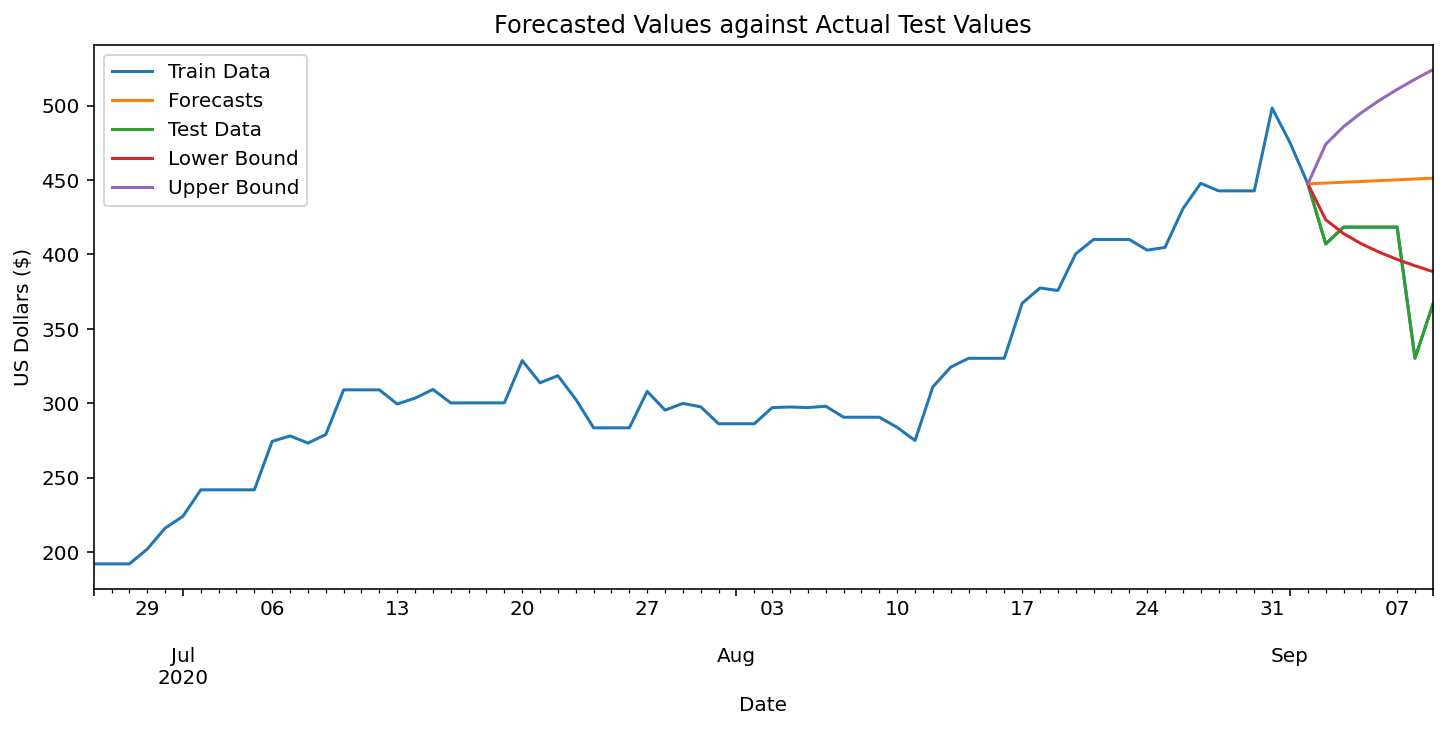

In [27]:
def connect_graphs(n):
    last_train_value = np.exp(df['log_close'][y_train.index].iloc[-1:])
    
    return pd.concat([last_train_value, n])

plt.figure(figsize = (12, 5))
plt.title('Forecasted Values against Actual Test Values')
plt.ylabel('US Dollars ($)')

np.exp(df['log_close'][3650:]).plot(label = 'Train Data') # Plotting from row 3,650 and beyond for a 
                                                          # zoomed view of forecasts

connect_graphs(np.exp(preds)).plot(label = 'Forecasts')
connect_graphs(np.exp(y_test)).plot(label = 'Test Data')

connect_graphs(lower).plot(label = 'Lower Bound')
connect_graphs(upper).plot(label = 'Upper Bound')

plt.legend();

The ACF and PACF plots below display the residuals from the ARIMA(0, 1, 0) model above. 

**arima.resid** returns all the residuals in the model. In this case, the residuals are the predicted day-to-day change in closing prices (recall that this is the first order difference of the original data)

There are no signs of correlations between the residuals in the model.

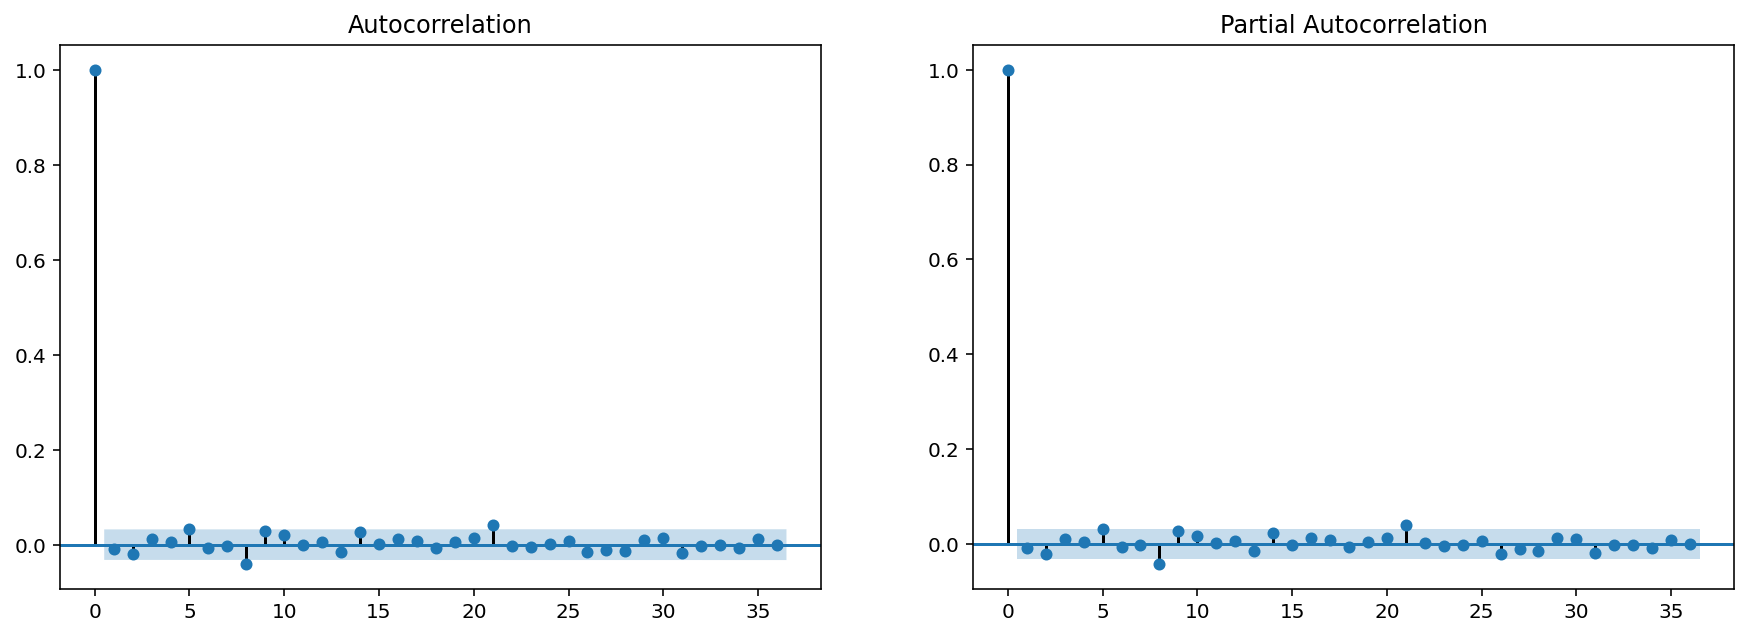

In [28]:
fig, ax = plt.subplots(ncols = 2, figsize = (15, 5))
plot_acf(arima.resid, ax = ax[0])
plot_pacf(arima.resid, ax = ax[1]);

# Recurrent Neural Network (LSTM)

Recurrent Neural Networks are very effective when forecasting time-series data because of their ability to store past information. Below is an implementation of a rudimentary Long-Short-Term Memory RNN.

In [29]:
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam

In [30]:
# Starting with a fresh copy of the original DataFrame

new_df = df.iloc[:, :6].copy().dropna() # This slice will remove the columns that were added from the previous analysis
                                        # while maintaining all the rows.

new_df.head()

,open,high,low,close,adj_close,volume
Date,,,,,,
2010-06-29,3.80,5.00,3.51,4.78,4.78,93831500.0
2010-06-30,5.16,6.08,4.66,4.77,4.77,85935500.0
2010-07-01,5.00,5.18,4.05,4.39,4.39,41094000.0
2010-07-02,4.60,4.62,3.74,3.84,3.84,25699000.0
2010-07-03,4.60,4.62,3.74,3.84,3.84,25699000.0


In [31]:
# For this model, we're splitting the data by year. Our training data will include all data prior to 2020
training_data = new_df[new_df.index.year < 2020].copy()

training_data.drop(columns = 'adj_close', inplace = True)

training_data

,open,high,low,close,volume
Date,,,,,
2010-06-29,3.80,5.00,3.51,4.78,93831500.0
2010-06-30,5.16,6.08,4.66,4.77,85935500.0
2010-07-01,5.00,5.18,4.05,4.39,41094000.0
2010-07-02,4.60,4.62,3.74,3.84,25699000.0
2010-07-03,4.60,4.62,3.74,3.84,25699000.0
...,...,...,...,...,...
2019-12-27,87.00,87.06,85.22,86.08,49728500.0
2019-12-28,87.00,87.06,85.22,86.08,49728500.0
2019-12-29,87.00,87.06,85.22,86.08,49728500.0


In [32]:
# The test data will only include data from the start of 2020 up to present day. This will act as the "unseen"
test_data = new_df[new_df.index.year >= 2020].copy()

test_data.drop(columns = 'adj_close', inplace = True)

test_data

,open,high,low,close,volume
Date,,,,,
2020-01-01,81.00,84.26,80.42,83.67,51428500.0
2020-01-02,84.90,86.14,84.34,86.05,47660500.0
2020-01-03,88.10,90.80,87.38,88.60,88892500.0
2020-01-04,88.10,90.80,87.38,88.60,88892500.0
2020-01-05,88.10,90.80,87.38,88.60,88892500.0
...,...,...,...,...,...
2020-09-05,402.81,428.00,372.02,418.32,110321900.0
2020-09-06,402.81,428.00,372.02,418.32,110321900.0
2020-09-07,402.81,428.00,372.02,418.32,110321900.0


In [33]:
'''
As always, we should normalize our data before feeding it into the RNN to prevent unequal weighting by the network
In this case, we're using the MinMaxScaler. 
The transformation is given by: 
X_sc = (X - min(X)) / (max(X) - min(X))
'''
mm = MinMaxScaler()
training_data_sc = mm.fit_transform(training_data)

# Preview
training_data_sc

array([[0.00680435, 0.01994506, 0.0061991 , 0.01951102, 0.50337694],
       [0.02303927, 0.03284366, 0.02017746, 0.01939058, 0.46074816],
       [0.02112928, 0.02209483, 0.01276285, 0.01481392, 0.21865873],
       ...,
       [1.        , 1.        , 0.99939225, 0.99867518, 0.2652745 ],
       [0.98519756, 0.98495163, 0.95842956, 0.96085752, 0.33655731],
       [0.92837531, 0.96655918, 0.94104777, 0.96964952, 0.27445243]])

In [34]:
X_train = []
y_train = []

# The first thing we need to do is restructure our training data. LSTMs expect the data to be in a 
# multi-dimensional array, so we'll construct that with the loop below.

# We're going to use every 60 days of historical data to predict the closing price on the 61st day and we want to
# iterate through the total length of our DataFrame:

for i in range(60, training_data_sc.shape[0]):
    X_train.append(training_data_sc[i-60: i])
    y_train.append(training_data_sc[i, 3]) # This slice takes the closing price of the 'ith' day

# Convert lists to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Confirm the shape of our restructured data
print(f'Samples: {X_train.shape[0]}\n'
      f'Time-steps per sample: {X_train.shape[1]}\n'
      f'Columns: {X_train.shape[2]}')

print(f'Length of Y outputs: {y_train.shape[0]}') # This should match the total rows of the X set

Samples: 3413
Time-steps per sample: 60
Columns: 5
Length of Y outputs: 3413


In [35]:
# Instantiate model
model = Sequential()

# First LSTM layer w/ 0.2 Dropout
model.add(LSTM(units = 50, # Arbitrary number of nodes used
               activation = 'relu',
               return_sequences = True,
               input_shape = (X_train.shape[1], 5))) # The input_shape is the dimensions of each row
model.add(Dropout(0.2)) # Dropout regularization method to prevent overfitting

# Second LSTM layer w/ 0.2 Dropout
model.add(LSTM(units = 60,
               activation = 'relu',
               return_sequences = True))
model.add(Dropout(0.2))

# Third LSTM layer w/ 0.2 Dropout
model.add(LSTM(units = 80,
               activation = 'relu',
               return_sequences = True))
model.add(Dropout(0.2))

# Fourth LSTM layer w/ 0.2 Dropout. We will not need to return the sequence for the final layer before output.
model.add(LSTM(units = 120,
               activation = 'relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units = 1)) # Output layer should return a single forecasted value

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            11200     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 60)            26640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 80)            45120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               9

In [37]:
model.compile(optimizer = Adam(), loss = 'mse')

In [38]:
model.fit(X_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10
107/107 [==============================] - 10s 91ms/step - loss: 0.0260 0s - 
Epoch 2/10
107/107 [==============================] - 9s 88ms/step - loss: 0.0044
Epoch 3/10
107/107 [==============================] - 10s 90ms/step - loss: 0.0043
Epoch 4/10
107/107 [==============================] - 9s 89ms/step - loss: 0.0038: 3s - l
Epoch 5/10
107/107 [==============================] - 9s 88ms/step - loss: 0.0039
Epoch 6/10
107/107 [==============================] - 11s 107ms/step - loss: 0.0033
Epoch 7/10
107/107 [==============================] - 12s 111ms/step - loss: 0.0032
Epoch 8/10
107/107 [==============================] - 12s 114ms/step - loss: 0.0031
Epoch 9/10
107/107 [==============================] - 13s 117ms/step - loss: 0.0028
Epoch 10/10
107/107 [==============================] - 13s 117ms/step - loss: 0.0026


In [39]:
# To forecast the closing price for the first day in the test data, I'll need to take the data from the previous 60 days
# or the final 60 rows in the training data.
past_60 = training_data.tail(60)

# Appending the test data to the data from previous 60 days for first iteration of the model
test_data_2 = past_60.append(test_data)

# Preview
test_data_2.head(65)

,open,high,low,close,volume
Date,,,,,
2019-11-02,63.26,63.30,61.96,62.66,31919500.0
2019-11-03,63.26,63.30,61.96,62.66,31919500.0
2019-11-04,62.96,64.39,61.85,63.49,43935000.0
2019-11-05,63.92,64.70,63.22,63.44,34717000.0
2019-11-06,63.60,65.34,62.90,65.32,39704500.0
...,...,...,...,...,...
2020-01-01,81.00,84.26,80.42,83.67,51428500.0
2020-01-02,84.90,86.14,84.34,86.05,47660500.0
2020-01-03,88.10,90.80,87.38,88.60,88892500.0


In [40]:
# Perform transformation on test data using the scaler fitted on the training data
inputs = mm.transform(test_data_2)
inputs

array([[0.71660499, 0.71623074, 0.71666464, 0.71660845, 0.16912761],
       [0.71660499, 0.71623074, 0.71666464, 0.71660845, 0.16912761],
       [0.71302376, 0.72924878, 0.71532758, 0.72660484, 0.23399666],
       ...,
       [4.76996538, 5.07189777, 4.48547466, 5.00012044, 0.59240499],
       [4.21117345, 4.36414666, 3.97325878, 3.93893773, 0.62017524],
       [4.21833592, 4.36725188, 4.11462258, 4.37335903, 0.42104931]])

In [41]:
X_test = []
y_test = []

# Before making our predictions, we'll reshape the test data the same way we did with the training data.
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 3])
    
X_test, y_test = np.array(X_test), np.array(y_test)
    
# Confirm the shape of our restructured data
print(f'Samples: {X_test.shape[0]}\n'
      f'Time-steps per sample: {X_test.shape[1]}\n'
      f'Columns: {X_test.shape[2]}')

print(f'Length of Y outputs: {y_test.shape[0]}')

Samples: 253
Time-steps per sample: 60
Columns: 5
Length of Y outputs: 253


In [42]:
# Forecasted values for test data using trained model
y_preds = model.predict(X_test)

# Preview of forecasts
y_preds

array([[0.8876314 ],
       [0.89008313],
       [0.89134943],
       [0.8928386 ],
       [0.895105  ],
       [0.89823097],
       [0.9025107 ],
       [0.9086017 ],
       [0.91694075],
       [0.9272103 ],
       [0.93880695],
       [0.9510887 ],
       [0.9631608 ],
       [0.9757508 ],
       [0.9902939 ],
       [1.0061902 ],
       [1.0208393 ],
       [1.0333501 ],
       [1.0436116 ],
       [1.0517026 ],
       [1.0578549 ],
       [1.0643722 ],
       [1.0737242 ],
       [1.0861709 ],
       [1.100979  ],
       [1.1167219 ],
       [1.1318103 ],
       [1.1439358 ],
       [1.1537651 ],
       [1.1624163 ],
       [1.174488  ],
       [1.1918066 ],
       [1.21338   ],
       [1.236391  ],
       [1.2659175 ],
       [1.318256  ],
       [1.3759035 ],
       [1.4222596 ],
       [1.4554833 ],
       [1.4779798 ],
       [1.4921764 ],
       [1.5049781 ],
       [1.5167738 ],
       [1.5280517 ],
       [1.5382549 ],
       [1.5492661 ],
       [1.561533  ],
       [1.573

In [43]:
# The current state of the forecasts is still normalized, so we'll perform some basic arimethic to reverse that.

# mm.scale_ returns an array with the relative scaling of each resepctive feature in the DataFrame passed in
# during the initial fitting of the transformer. We are interested in the fourth element of this list, 
# a.k.a the closing price
mm.scale_

array([1.19374478e-02, 1.19431506e-02, 1.21550991e-02, 1.20438396e-02,
       5.39878096e-09])

In [58]:
# We're going to reverse the effects of the scaler through dividing the scaled predicted values with the scale
cp_scale = 1/mm.scale_[3]

print(cp_scale)

y_preds_unscaled = y_preds * cp_scale

y_preds_unscaled[:10]

83.03


array([[73.700035],
       [73.9036  ],
       [74.00874 ],
       [74.132385],
       [74.320564],
       [74.58012 ],
       [74.93546 ],
       [75.4412  ],
       [76.13359 ],
       [76.98627 ]], dtype=float32)

# Visualization

In [61]:
# For simplicity, I'll create a new column in the original test set for the LSTM forecasted closing prices
test_data['lstm_predicted_close'] = y_preds_unscaled

test_data.head()

,open,high,low,close,volume,lstm_predicted_close
Date,,,,,,
2020-01-01,81.0,84.26,80.42,83.67,51428500.0,73.700035
2020-01-02,84.9,86.14,84.34,86.05,47660500.0,73.903603
2020-01-03,88.1,90.80,87.38,88.60,88892500.0,74.008743
2020-01-04,88.1,90.80,87.38,88.60,88892500.0,74.132385
2020-01-05,88.1,90.80,87.38,88.60,88892500.0,74.320564


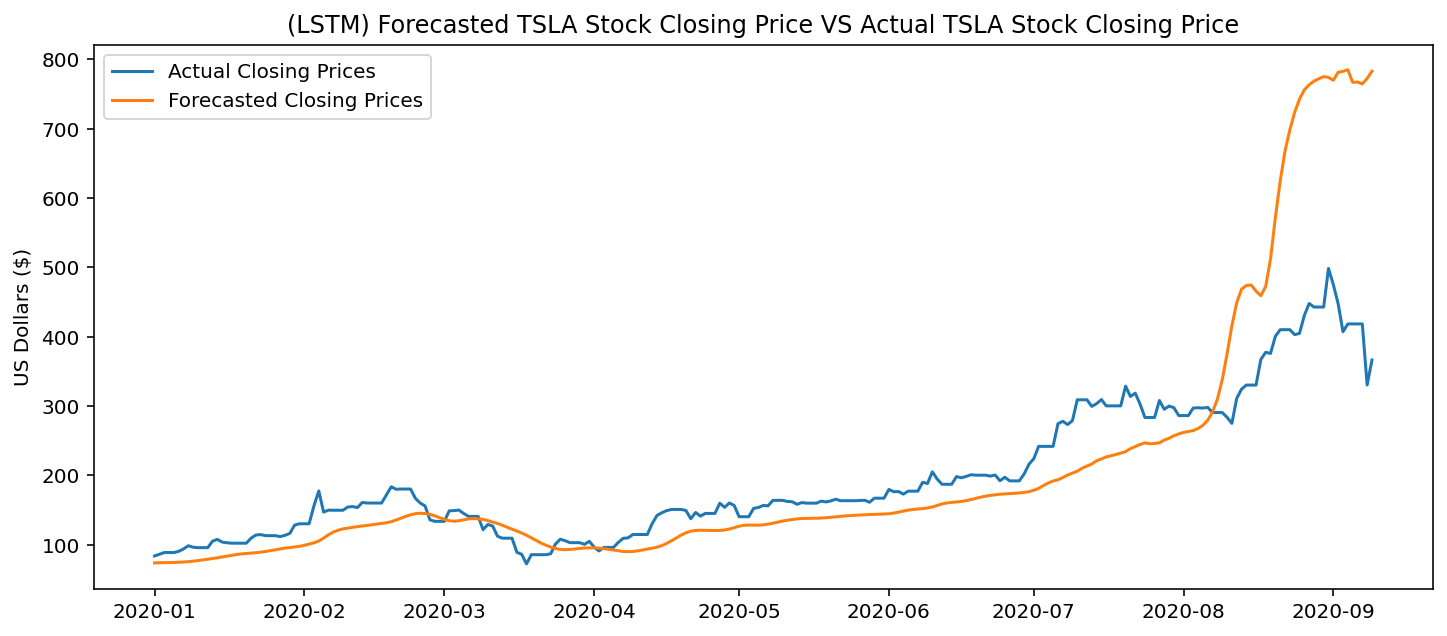

In [68]:
plt.figure(figsize = (12, 5))
plt.title('(LSTM) Forecasted TSLA Stock Closing Price VS Actual TSLA Stock Closing Price')
plt.ylabel('US Dollars ($)')

plt.plot(test_data['close'], label = 'Actual Closing Prices')
plt.plot(test_data['lstm_predicted_close'], label = 'Forecasted Closing Prices')

plt.legend();

# Observations

The model actually performed well while the stock price followed a modest upward trend but may have overfit when the price suddenly spiked towards the end of August. We can see that the predictions skyrocketed proportionate to the sudden exponential growth in the actual stock price (triggered by positive news reported by Tesla in the 2nd quarter despite the pandemic).